In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


Loading images from: /content/drive/MyDrive/AnomalyGPT/covid radiology/COVID-19_Radiography_Dataset/COVID/images
Loading masks from: /content/drive/MyDrive/AnomalyGPT/covid radiology/COVID-19_Radiography_Dataset/COVID/masks
Category: COVID
  Images loaded: 3616
  Masks loaded: 3616
  Valid pairs: 3616
Loading images from: /content/drive/MyDrive/AnomalyGPT/covid radiology/COVID-19_Radiography_Dataset/Lung_Opacity/images
Loading masks from: /content/drive/MyDrive/AnomalyGPT/covid radiology/COVID-19_Radiography_Dataset/Lung_Opacity/masks
Category: Lung_Opacity
  Images loaded: 6012
  Masks loaded: 6012
  Valid pairs: 6012
Loading images from: /content/drive/MyDrive/AnomalyGPT/covid radiology/COVID-19_Radiography_Dataset/Normal/images
Loading masks from: /content/drive/MyDrive/AnomalyGPT/covid radiology/COVID-19_Radiography_Dataset/Normal/masks
Category: Normal
  Images loaded: 10192
  Masks loaded: 4253
  Valid pairs: 4253
Loading images from: /content/drive/MyDrive/AnomalyGPT/covid radio

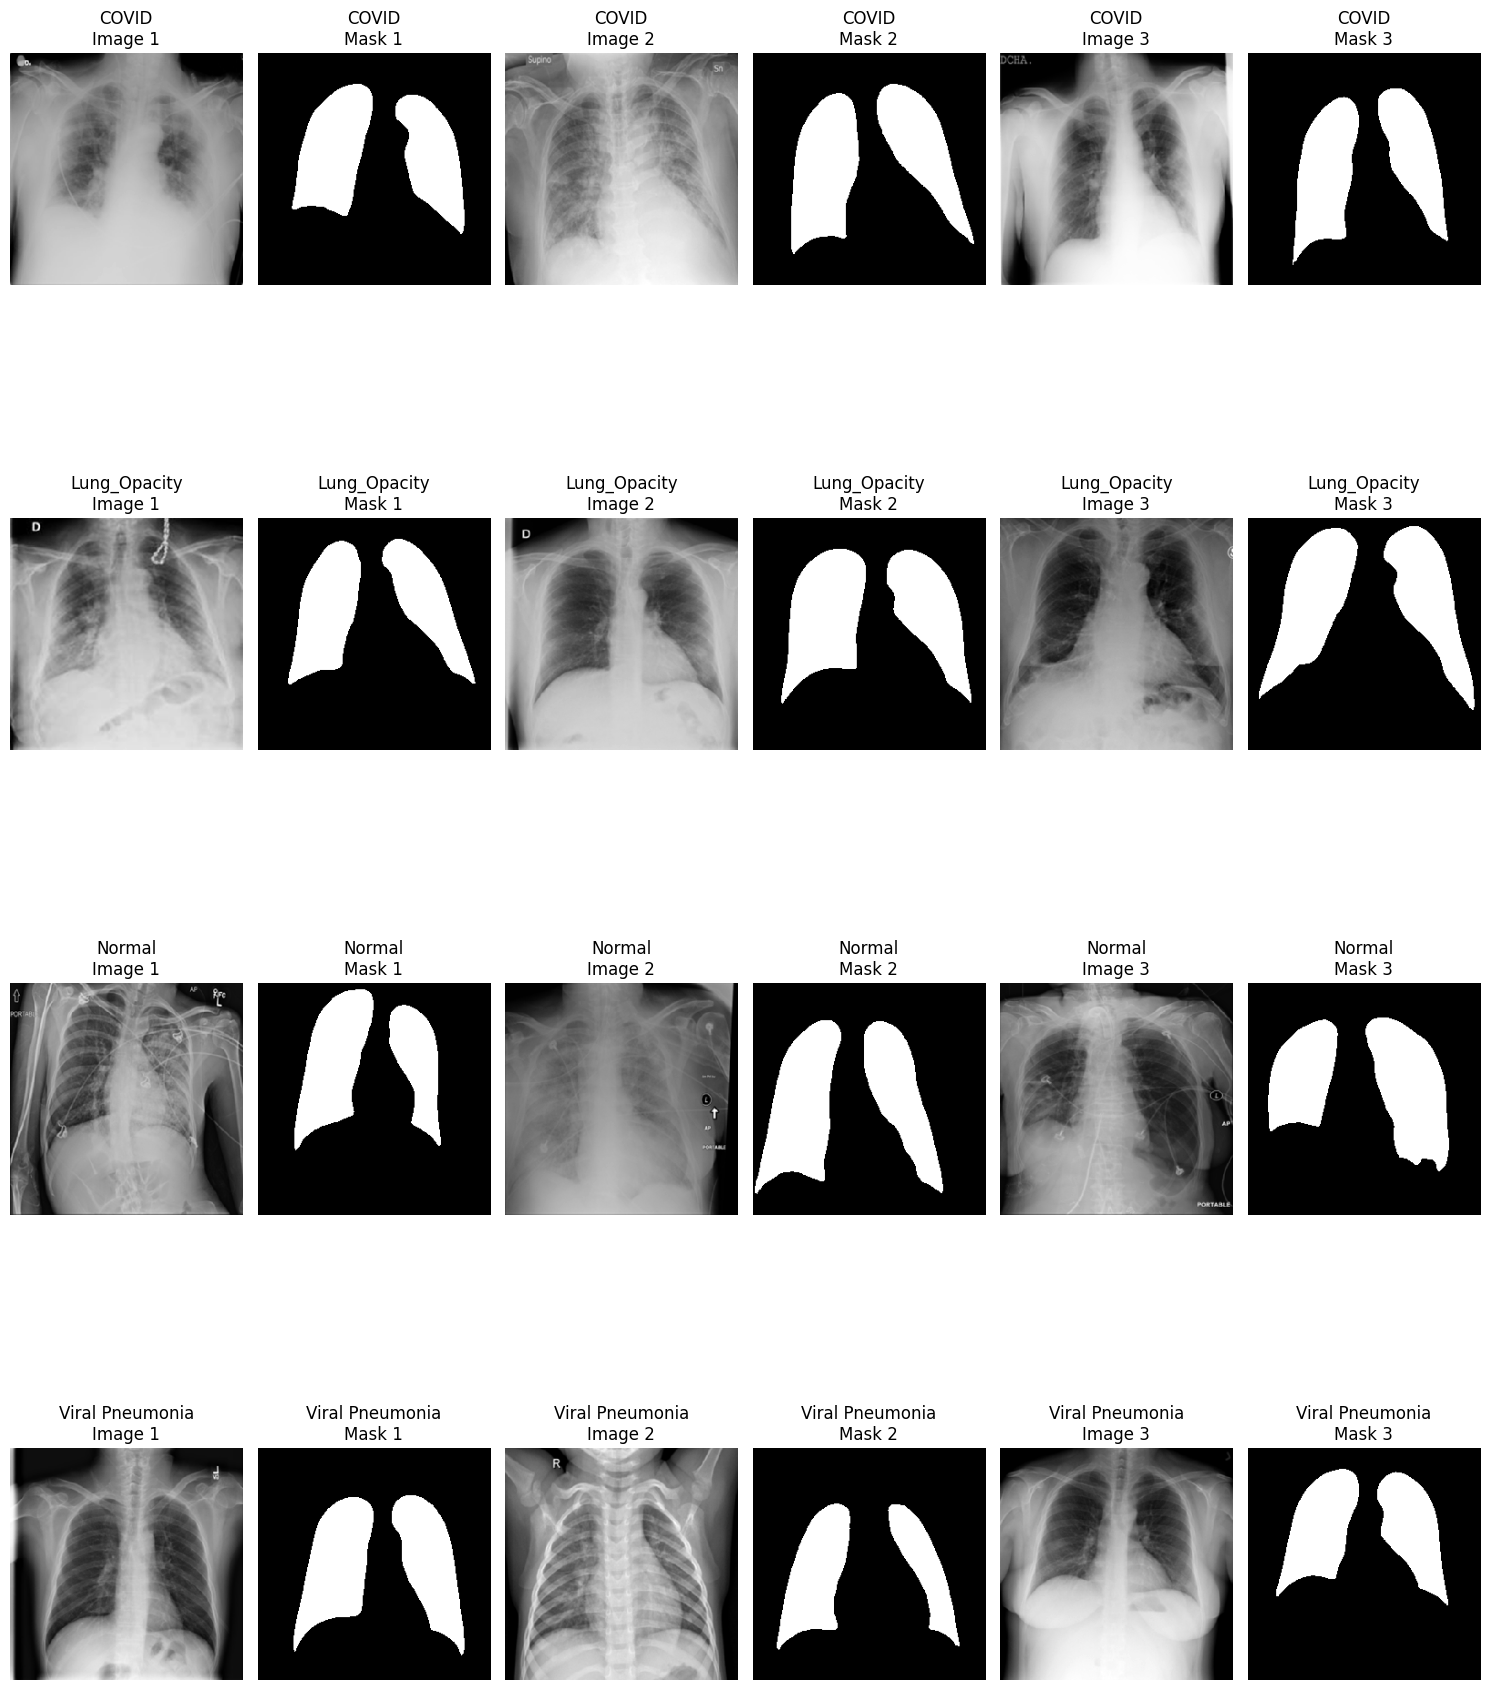


Image array shape: (13881, 256, 256, 1)
Image data type: float32
Image min value: 0.0
Image max value: 1.0

Mask array shape: (13881, 256, 256, 1)
Mask data type: float32
Mask min value: 0.0
Mask max value: 1.0


In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define constants
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 50

# Define the dataset path
base_path = '/content/drive/MyDrive/AnomalyGPT/covid radiology/COVID-19_Radiography_Dataset'
categories = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Set image size
IMG_SIZE = (256, 256)

def load_images_from_folder(folder_path):
    images = []
    filenames = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            file_path = os.path.join(folder_path, filename)
            try:
                img = load_img(file_path, color_mode='grayscale', target_size=IMG_SIZE)
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                filenames.append(filename)
            except Exception as e:
                print(f"Error loading {filename}: {str(e)}")
    return np.array(images), filenames

def load_data_from_categories(base_path, categories):
    all_images = []
    all_masks = []
    for category in categories:
        image_folder = os.path.join(base_path, category, 'images')
        mask_folder = os.path.join(base_path, category, 'masks')

        print(f"Loading images from: {image_folder}")
        images, image_filenames = load_images_from_folder(image_folder)

        print(f"Loading masks from: {mask_folder}")
        masks, mask_filenames = load_images_from_folder(mask_folder)

        print(f"Category: {category}")
        print(f"  Images loaded: {len(images)}")
        print(f"  Masks loaded: {len(masks)}")

        # Ensure we only keep pairs where both image and mask exist
        valid_pairs = set(image_filenames) & set(mask_filenames)
        valid_indices = [i for i, filename in enumerate(image_filenames) if filename in valid_pairs]

        valid_images = images[valid_indices]
        valid_masks = masks[[mask_filenames.index(filename) for filename in image_filenames if filename in valid_pairs]]

        print(f"  Valid pairs: {len(valid_pairs)}")

        all_images.extend(valid_images)
        all_masks.extend(valid_masks)

    return np.array(all_images), np.array(all_masks)

# Load all images and masks from all categories
images, masks = load_data_from_categories(base_path, categories)

print(f"\nTotal loaded: {len(images)} images and {len(masks)} masks")
if len(images) > 0:
    print(f"Image shape: {images[0].shape}")
if len(masks) > 0:
    print(f"Mask shape: {masks[0].shape}")

# Display the first few images and masks from each category
num_display = 3  # Number of images to display per category
num_categories = len(categories)
images_per_category = len(images) // num_categories

fig, axes = plt.subplots(num_categories, num_display * 2, figsize=(15, 5 * num_categories))

for i, category in enumerate(categories):
    start_idx = i * images_per_category
    for j in range(num_display):
        idx = start_idx + j
        if idx < len(images):
            axes[i, j*2].imshow(images[idx].squeeze(), cmap='gray')
            axes[i, j*2].set_title(f'{category}\nImage {j+1}')
            axes[i, j*2].axis('off')

            axes[i, j*2+1].imshow(masks[idx].squeeze(), cmap='gray')
            axes[i, j*2+1].set_title(f'{category}\nMask {j+1}')
            axes[i, j*2+1].axis('off')
        else:
            axes[i, j*2].axis('off')
            axes[i, j*2+1].axis('off')

plt.tight_layout()
plt.show()

# Print some statistics
if len(images) > 0:
    print(f"\nImage array shape: {images.shape}")
    print(f"Image data type: {images.dtype}")
    print(f"Image min value: {images.min()}")
    print(f"Image max value: {images.max()}")

if len(masks) > 0:
    print(f"\nMask array shape: {masks.shape}")
    print(f"Mask data type: {masks.dtype}")
    print(f"Mask min value: {masks.min()}")
    print(f"Mask max value: {masks.max()}")



In [ ]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder (Downsampling)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder (Upsampling)
    up5 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

Training set: 11104 images
Test set: 2777 images
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 256, 256, 64)         640       ['input_4[0][0]']             
                                                                                                  
 conv2d_46 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_45[0][0]']           
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_46[0][0]']           
 g2D)                                      

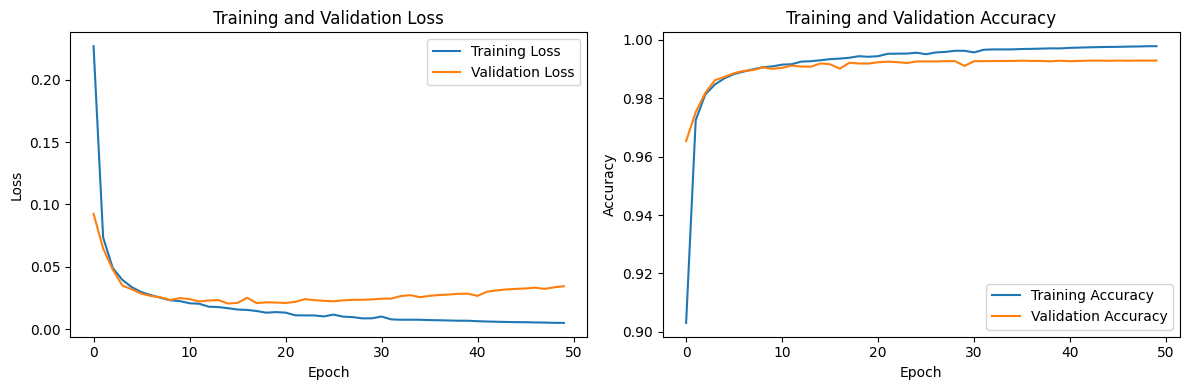


Test Loss: 0.0344
Test Accuracy: 0.9929


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'covid_segmentation_model.h5'


In [ ]:
# Ensure images and masks are the correct shape
assert images[0].shape == (256, 256, 1), f"Unexpected image shape: {images[0].shape}"
assert masks[0].shape == (256, 256, 1), f"Unexpected mask shape: {masks[0].shape}"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Create and compile the model
model = unet_model(input_size=(256, 256, 1))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=50, verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the model
model.save('covid_segmentation_model.h5')
print("Model saved as 'covid_segmentation_model.h5'")


Run the cell below only when serious about hyperparameter tuning

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

IMG_SIZE = (256, 256)

# Data loading functions (assume they're the same as before)
# def load_images_from_folder(folder_path):
#     ...

# def load_data_from_categories(base_path, categories):
#     ...

def unet_model(input_size=(256, 256, 1), filters=64, dropout_rate=0.1):
    inputs = Input(input_size)

    # Encoder (Downsampling)
    conv1 = Conv2D(filters, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(filters, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(dropout_rate)(pool1)

    conv2 = Conv2D(filters*2, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(filters*2, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(dropout_rate)(pool2)

    conv3 = Conv2D(filters*4, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(filters*4, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(dropout_rate)(pool3)

    # Bridge
    conv4 = Conv2D(filters*8, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(filters*8, 3, activation='relu', padding='same')(conv4)

    # Decoder (Upsampling)
    up5 = Conv2DTranspose(filters*4, 2, strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3])
    up5 = Dropout(dropout_rate)(up5)
    conv5 = Conv2D(filters*4, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(filters*4, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(filters*2, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2])
    up6 = Dropout(dropout_rate)(up6)
    conv6 = Conv2D(filters*2, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(filters*2, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1])
    up7 = Dropout(dropout_rate)(up7)
    conv7 = Conv2D(filters, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(filters, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Main script
base_path = 'path/to/your/dataset'
categories = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Load all images and masks from all categories
images, masks = load_data_from_categories(base_path, categories)

print(f"\nTotal loaded: {len(images)} images and {len(masks)} masks")
print(f"Image shape: {images[0].shape}")
print(f"Mask shape: {masks[0].shape}")

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Define hyperparameters to try
hyperparameters = [
    {'filters': 32, 'dropout_rate': 0.1},
    {'filters': 64, 'dropout_rate': 0.1},
    {'filters': 32, 'dropout_rate': 0.2},
    {'filters': 64, 'dropout_rate': 0.2},
]

# Callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)

best_model = None
best_val_loss = float('inf')

for params in hyperparameters:
    print(f"\nTraining model with parameters: {params}")
    model = unet_model(input_size=(256, 256, 1), **params)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=16,
        epochs=50,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

print("\nTraining completed. Best model found.")

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the best model
best_model.save('best_covid_segmentation_model.h5')
print("Best model saved as 'best_covid_segmentation_model.h5'")

# Plot a sample prediction
n = 5  # number of images to display
fig, axes = plt.subplots(3, n, figsize=(20, 12))
for i in range(n):
    idx = np.random.randint(0, X_test.shape[0])
    axes[0, i].imshow(X_test[idx].squeeze(), cmap='gray')
    axes[0, i].set_title('Original Image')
    axes[0, i].axis('off')

    axes[1, i].imshow(y_test[idx].squeeze(), cmap='gray')
    axes[1, i].set_title('True Mask')
    axes[1, i].axis('off')

    prediction = best_model.predict(X_test[idx][np.newaxis, ...])[0]
    axes[2, i].imshow(prediction.squeeze(), cmap='gray')
    axes[2, i].set_title('Predicted Mask')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()